In [103]:
import re
from nltk.text import Text
import numpy as np
from trtokenizer.tr_tokenizer import SentenceTokenizer, WordTokenizer

In [2]:
sent_tok = SentenceTokenizer()
word_tok = WordTokenizer()

In [2]:
with open('9thgrade_sentences.txt', 'r', encoding = 'utf-8') as f1:
    lines = f1.readlines()
    minority_9 = [line.rstrip() for line in lines]
        
with open('10thgrade_sentences.txt', 'r', encoding = "utf-8") as f2:
    lines = f2.readlines()
    minority_10 = [line.rstrip() for line in lines]
        
with open('11thgrade_sentences.txt', 'r', encoding = "utf-8") as f3:
    lines = f3.readlines()
    minority_11 = [line.rstrip() for line in lines]
        
with open('12thgrade_sentences.txt', 'r', encoding = "utf-8") as f4:
    lines = f4.readlines()
    minority_12 = [line.rstrip() for line in lines]

In [12]:
import zeyrek
analyzer = zeyrek.MorphAnalyzer()

def lemmatize_text(text):
    
    lemmatized_words = []
    
    for sent in text:
        for item in analyzer.lemmatize(sent):
            if item[0].istitle():
                lemmatized_words.append(item[1][0].title())
            else:
                lemmatized_words.append(item[1][0])
    
    sentences_stemmed = list(sent_tok.tokenize(" ".join(lemmatized_words)))
    return sentences_stemmed

In [13]:
txt9_minority_lemmatized = lemmatize_text(minority_9)
txt10_minority_lemmatized = lemmatize_text(minority_10)
txt11_minority_lemmatized = lemmatize_text(minority_11)
txt12_minority_lemmatized = lemmatize_text(minority_12)

In [14]:
print(txt9_minority_lemmatized[:3])
print("-------------------------------------------------------------------")
print(txt10_minority_lemmatized[:3])
print("-------------------------------------------------------------------")
print(txt11_minority_lemmatized[:3])
print("-------------------------------------------------------------------")
print(txt12_minority_lemmatized[50:60])
print("-------------------------------------------------------------------")

['Batı dil karşı Yunan “ istoria ” dan türemek Historia ve historiedir .', 'Bu bilim insan bazı bu yazı ; Prusya , Iskitler , Yunan ve Latin ait olmak ileri sürmek .', 'Sümer , Babil , Mısır , Yunan , İbranî , Roma , Aztek , Mayalamak , Çin , Hint , Tibet , Türk ve Arap gibi çok çeşitli millet ve topluluk değişik takvim meydan getirmek .']
-------------------------------------------------------------------
['Bu Döne Anadolu ; Rum ve Ermeni birlik Süryanî , Arap ve Türk bulmak .', 'Bu Döne Anadolu ; Rum ve Ermeni birlik Süryanî , Arap ve Türk bulmak .', 'Özellikle mezhep fark dolay Bizans tarafından büyük baskı ve işkence maruz Kalan Ermeni , Türk akın hiç diremek göstermek .']
-------------------------------------------------------------------
['Osmanlı As bütün Hristiyan dünya hedeflemek söylemek papa , Avrupa devlet kutsal bir Çat altı toplamak amaçlamak ve bu da başarı olmak .', 'Merkez yönetim ve ordu yapmak düzenlemek yan sır Ülke iç Hristiyan Yaşam koşul iyi iç büyük Çaba harcama

In [15]:
#Writing lemmatized minority sentences to txt files to use in other sentiment analysis approaches

with open('9thgrade_sentences_lemmatized.txt', 'w', encoding = 'utf-8') as f1:
    for sent in txt9_minority_lemmatized:
        f1.write("%s\n" % sent)
        
with open('10thgrade_sentences_lemmatized.txt', 'w', encoding = "utf-8") as f2:
    for sent in txt10_minority_lemmatized:
        f2.write("%s\n" % sent)
        
with open('11thgrade_sentences_lemmatized.txt', 'w', encoding = "utf-8") as f3:
    for sent in txt11_minority_lemmatized:
        f3.write("%s\n" % sent)
        
with open('12thgrade_sentences_lemmatized.txt', 'w', encoding = "utf-8") as f4:
    for sent in txt12_minority_lemmatized:
        f4.write("%s\n" % sent)

## Running the Sentiment Lexicon Based Analysis

The following blocks of codes will analyse the lemmatized sentences based on SentiTurkNet Sentiment Lexicon. The approach does not merely count the number of negative or positive words in a sentence but computes an overall probability based on each word's entry.

In [16]:
import pandas as pd

sent_lexicon = pd.read_excel('STN.xlsx')

In [17]:
print(sent_lexicon.head())
sent_lexicon = sent_lexicon[["synonyms", "neg value", "obj value", "pos value", "Eng Synonyms"]]

       synonyms                                  Turkish Gloss Polarity Label  \
0   ayva reçeli  Meyveleri şekerle kaynatarak hazırlanan tatlı              o   
1    gül reçeli  Meyveleri şekerle kaynatarak hazırlanan tatlı              o   
2  incir reçeli  Meyveleri şekerle kaynatarak hazırlanan tatlı              o   
3         iştah                             Yemek yeme isteği.              o   
4       iştahlı                           İştahı olan, boğazlı              p   

  POS tag  neg value  obj value  pos value Eng Synonyms  \
0       n       0.06      0.872      0.068        jam#1   
1       n       0.06      0.872      0.068        jam#1   
2       n       0.06      0.872      0.068        jam#1   
3       n       0.06      0.872      0.068          NaN   
4       a       0.06      0.462      0.478          NaN   

               English Gloss  SWNpos  SWNneg  
0  preserve of crushed fruit     0.0     0.0  
1  preserve of crushed fruit     0.0     0.0  
2  preserve of cr

In [18]:
#This step eliminates NaN entries in the lexicon (due to the fact that SentiTurkNet is constructed based on English SentiNet)

print(sent_lexicon.shape)
print(sent_lexicon['synonyms'].isnull().values.any())
sent_lexicon = sent_lexicon[sent_lexicon['synonyms'].notna()]
print(sent_lexicon.shape)

(14795, 5)
True
(13526, 5)


In [30]:
# Lexicon-based sentiment classifier function. The function matches the words found in the input sentences with the words
# in the sentiment lexicon. It spits out polarity values (positive/negative) regarding the input sentence.


def sentiment_classifier_prob(text):
    text = text.split()
    sentence_values = pd.DataFrame()
    for word in text:
        word = word.lower()
        try:
            if  sent_lexicon['synonyms'].str.contains(word).any():
                synset_vals = sent_lexicon[sent_lexicon['synonyms'].str.contains(word)][['neg value', 'obj value', 'pos value']]
                word_negative_prob = sum(synset_vals["neg value"]) / synset_vals.shape[0]
                word_obj_prob = sum(synset_vals["obj value"]) / synset_vals.shape[0]
                word_pos_prob = sum(synset_vals["pos value"]) / synset_vals.shape[0]
                merged = {"neg": word_negative_prob, "obj": word_obj_prob, "pos": word_pos_prob}
                sentence_values = sentence_values.append(merged, ignore_index=True)
            else:
                continue
        except:
            continue
    
    total_neg = sum(sentence_values["neg"]) / sentence_values.shape[0]
    total_obj = sum(sentence_values["obj"]) / sentence_values.shape[0]
    total_pos = sum(sentence_values["pos"]) / sentence_values.shape[0]
    
    if total_obj > .87 or np.abs(total_neg - total_pos) < 0.02:
        verdict = 2
    elif total_neg > total_pos:
        verdict = 1
    elif total_pos > total_neg:
        verdict = 3
    else:
        print("I cannot decide. There is something unexpected!")
        verdict = NaN
        
    return verdict
                                                    

In [52]:
def sentiment_classifier_count(text):
    sentence_values = pd.DataFrame()
    text = text.split()
    for word in text:
        word = word.lower()
        try:
            if  sent_lexicon['synonyms'].str.contains(word).any():
                synset_vals = sent_lexicon[sent_lexicon['synonyms'].str.contains(word)][['neg value', 'obj value', 'pos value']]
                word_negative_prob = sum(synset_vals["neg value"]) / synset_vals.shape[0]
                word_obj_prob = sum(synset_vals["obj value"]) / synset_vals.shape[0]
                word_pos_prob = sum(synset_vals["pos value"]) / synset_vals.shape[0]
                merged = {"neg": word_negative_prob, "obj": word_obj_prob, "pos": word_pos_prob}
                sentence_values = sentence_values.append(merged, ignore_index=True)
            else:
                continue
        except:
            continue
    
    neg_words_num = 0
    obj_words_num = 0
    pos_words_num = 0

    try:
        for ix, row in sentence_values.iterrows():
            neg = (row[0])
            obj = (row[1])
            pos = (row[2])
            row_values = [neg, obj, pos]
            if row_values.index(max(row_values)) == 0:
                neg_words_num = neg_words_num + 1
            
            if row_values.index(max(row_values)) == 1:
                obj_words_num = obj_words_num +1
            
            if row_values.index(max(row_values)) == 2:
                pos_words_num = pos_words_num + 1
            
        verdict_counts = (neg_words_num, obj_words_num, pos_words_num)
            
        if verdict_counts.index(max(verdict_counts)) == 0:
            verdict = 'negative'
        
        elif verdict_counts.index(max(verdict_counts)) == 1:
            if verdict_counts[0] > verdict_counts[2]:
                verdict = 'negative'
                
            elif verdict_counts[0] < verdict_counts[2]:
                verdict = 'positive'
            else:
                verdict = 'objective'
            
        elif verdict_counts.index(max(verdict_counts)) == 2:
            verdict = 'positive'
        
        else:
            verdict = 'unidentified'
        
    except:
        verdict = 'unidentified'
    return verdict

# 12th Grade Textbook

## Probability-based

In [34]:
classified_12 = []

for sent in txt12_minority_lemmatized:
    if len(sent.split()) > 6:
        verdict = sentiment_classifier_prob(sent)
        row = (str(sent), verdict)
        classified_12.append(row)    
    else:
        continue

In [154]:
df_classified12 = pd.DataFrame(classified_12, columns = ["Sentence", "Class"])
print(df_classified12.head())
print("----------------------------")
print(df_classified12["Class"].value_counts())

                                            Sentence  Class
0  3 Ermeni Faaliyet ve A Terör Örgüt ..............      1
1  Bilgi Not Bilgi Not Ali Rıza Efendi aile ; Osm...      3
2  Zübeyde Han ata , Fatih Sultan Mehmet dönem , ...      3
3  Iz Bırakmak Şehir Selanik : Mustafa Kemal doğu...      2
4  Nüfus Çoğun Türk o Selanik ; Yunan , Ermek , B...      3
----------------------------
1    787
3    782
2    604
Name: Class, dtype: int64


In [38]:
# Writing results to a csv file

df_classified12.to_csv('lexicon_probbased_12.csv', index=False)

## Count-based function

In [53]:
classified_12_count = []

for sent in txt12_minority_lemmatized:
    if len(sent.split()) > 6:
        verdict = sentiment_classifier_count(sent)
        row = (str(sent), verdict)
        classified_12_count.append(row)    
    else:
        continue

In [155]:
df_classified12_count = pd.DataFrame(classified_12_count, columns = ["Sentence", "Class"])
print(df_classified12_count.head())
print("----------------------------")
print(df_classified12_count["Class"].value_counts())

                                            Sentence     Class
0  3 Ermeni Faaliyet ve A Terör Örgüt ..............  negative
1  Bilgi Not Bilgi Not Ali Rıza Efendi aile ; Osm...  positive
2  Zübeyde Han ata , Fatih Sultan Mehmet dönem , ...  positive
3  Iz Bırakmak Şehir Selanik : Mustafa Kemal doğu...  positive
4  Nüfus Çoğun Türk o Selanik ; Yunan , Ermek , B...  negative
----------------------------
objective    918
negative     678
positive     577
Name: Class, dtype: int64


In [55]:
df_classified12_count.to_csv('lexicon_countbased_12.csv', index=False)

# 11th Grade Textbook

## Probability-based

In [57]:
classified_11 = []

for sent in txt11_minority_lemmatized:
    if len(sent.split()) > 6:
        verdict = sentiment_classifier_prob(sent)
        row = (str(sent), verdict)
        classified_11.append(row)    
    else:
        continue

In [157]:
df_classified11 = pd.DataFrame(classified_11, columns = ["Sentence", "Class"])
print(df_classified11.head())
print("----------------------------")
print(df_classified11["Class"].value_counts())

                                            Sentence  Class
0  Osmanlı As bütün Hristiyan dünya hedeflemek sö...      3
1  Merkez yönetim ve ordu yapmak düzenlemek yan s...      3
2  Bu yüzyıl güç kaybetmek Venedik , kendi iç ası...      1
3  Bu reform Katolik Hristiyan karşı girişmek har...      2
4  Bu karşı Rus , Osmanlı Toprak ticaret yapmak v...      2
----------------------------
3    111
2     64
1     54
Name: Class, dtype: int64


In [59]:
# Writing results to a csv file

df_classified11.to_csv('lexicon_probbased_11.csv', index=False)

## Count-based

In [60]:
classified_11_count = []

for sent in txt11_minority_lemmatized:
    if len(sent.split()) > 6:
        verdict = sentiment_classifier_count(sent)
        row = (str(sent), verdict)
        classified_11_count.append(row)    
    else:
        continue

In [158]:
df_classified11_count = pd.DataFrame(classified_11_count, columns = ["Sentence", "Class"])
print(df_classified11_count.head())
print("----------------------------")
print(df_classified11_count["Class"].value_counts())

                                            Sentence      Class
0  Osmanlı As bütün Hristiyan dünya hedeflemek sö...   positive
1  Merkez yönetim ve ordu yapmak düzenlemek yan s...   positive
2  Bu yüzyıl güç kaybetmek Venedik , kendi iç ası...   negative
3  Bu reform Katolik Hristiyan karşı girişmek har...   negative
4  Bu karşı Rus , Osmanlı Toprak ticaret yapmak v...  objective
----------------------------
objective    84
positive     74
negative     71
Name: Class, dtype: int64


In [62]:
df_classified11_count.to_csv('lexicon_countbased_11.csv', index=False)

# 10th Grade Textbook

## Probability-based function

In [63]:
classified_10 = []

for sent in txt10_minority_lemmatized:
    if len(sent.split()) > 6:
        verdict = sentiment_classifier_prob(sent)
        row = (str(sent), verdict)
        classified_10.append(row)    
    else:
        continue

In [159]:
df_classified10 = pd.DataFrame(classified_10, columns = ["Sentence", "Class"])
print(df_classified10.head())
print("----------------------------")
print(df_classified10["Class"].value_counts())

                                            Sentence  Class
0  Bu Döne Anadolu ; Rum ve Ermeni birlik Süryanî...      2
1  Bu Döne Anadolu ; Rum ve Ermeni birlik Süryanî...      2
2  Özellikle mezhep fark dolay Bizans tarafından ...      1
3  Hatta Ermek Yerel hanedan , derebeyi aile , As...      2
4  XI . yüzyıl Doğu Anadolu Ermek ve Süryanî ile ...      1
----------------------------
2    70
1    69
3    69
Name: Class, dtype: int64


In [65]:
# Writing results to a csv file

df_classified10.to_csv('lexicon_probbased_10.csv', index=False)

## Count-based function

In [66]:
classified_10_count = []

for sent in txt10_minority_lemmatized:
    if len(sent.split()) > 6:
        verdict = sentiment_classifier_count(sent)
        row = (str(sent), verdict)
        classified_10_count.append(row)    
    else:
        continue

In [160]:
df_classified10_count = pd.DataFrame(classified_10_count, columns = ["Sentence", "Class"])
print(df_classified10_count.head())
print("----------------------------")
print(df_classified10_count["Class"].value_counts())

                                            Sentence      Class
0  Bu Döne Anadolu ; Rum ve Ermeni birlik Süryanî...  objective
1  Bu Döne Anadolu ; Rum ve Ermeni birlik Süryanî...  objective
2  Özellikle mezhep fark dolay Bizans tarafından ...   negative
3  Hatta Ermek Yerel hanedan , derebeyi aile , As...  objective
4  XI . yüzyıl Doğu Anadolu Ermek ve Süryanî ile ...   negative
----------------------------
objective    83
negative     76
positive     49
Name: Class, dtype: int64


In [68]:
# Writing results to a csv file

df_classified10_count.to_csv('lexicon_countbased_10.csv', index=False)

# 9th Grade Textbook

## Probability-based

In [69]:
classified_9 = []

for sent in txt9_minority_lemmatized:
    if len(sent.split()) > 6:
        verdict = sentiment_classifier_prob(sent)
        row = (str(sent), verdict)
        classified_9.append(row)    
    else:
        continue

In [161]:
df_classified9 = pd.DataFrame(classified_9, columns = ["Sentence", "Class"])
print(df_classified9.head())
print("----------------------------")
print(df_classified9["Class"].value_counts())

                                            Sentence  Class
0  Batı dil karşı Yunan “ istoria ” dan türemek H...      1
1  Bu bilim insan bazı bu yazı ; Prusya , Iskitle...      2
2  Sümer , Babil , Mısır , Yunan , İbranî , Roma ...      2
3  Örnek İbranî mö 3761deki Yaradılış ( Tekvin ) ...      2
4  Örnek İbranî mö 3761deki Yaradılış ( Tekvin ) ...      2
----------------------------
2    45
3    36
1    27
Name: Class, dtype: int64


In [71]:
# Writing results to a csv file

df_classified9.to_csv('lexicon_probbased_9.csv', index=False)

## Count-based

In [72]:
classified_9_count = []

for sent in txt9_minority_lemmatized:
    if len(sent.split()) > 6:
        verdict = sentiment_classifier_count(sent)
        row = (str(sent), verdict)
        classified_9_count.append(row)    
    else:
        continue

In [162]:
df_classified9_count = pd.DataFrame(classified_9_count, columns = ["Sentence", "Class"])
print(df_classified9_count.head())
print("----------------------------")
print(df_classified9_count["Class"].value_counts())

                                            Sentence      Class
0  Batı dil karşı Yunan “ istoria ” dan türemek H...  objective
1  Bu bilim insan bazı bu yazı ; Prusya , Iskitle...  objective
2  Sümer , Babil , Mısır , Yunan , İbranî , Roma ...   negative
3  Örnek İbranî mö 3761deki Yaradılış ( Tekvin ) ...  objective
4  Örnek İbranî mö 3761deki Yaradılış ( Tekvin ) ...  objective
----------------------------
objective    43
negative     39
positive     26
Name: Class, dtype: int64


In [74]:
# Writing results to a csv file

df_classified9_count.to_csv('lexicon_countbased_9.csv', index=False)

# Plotting

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

## Merging results

In [164]:
df_classified9_count["Grade"] = int(9)
df_classified9["Grade"] = int(9)

df_classified9.loc[df_classified9.Class == 1, 'Class'] = "negative"
df_classified9.loc[df_classified9.Class == 2, 'Class'] = "objective"
df_classified9.loc[df_classified9.Class == 3, 'Class'] = "positive"

In [165]:
df_classified10_count["Grade"] = int(10)
df_classified10["Grade"] = int(10)

df_classified10.loc[df_classified10.Class == 1, 'Class'] = "negative"
df_classified10.loc[df_classified10.Class == 2, 'Class'] = "objective"
df_classified10.loc[df_classified10.Class == 3, 'Class'] = "positive"

In [166]:
df_classified11_count["Grade"] = int(11)
df_classified11["Grade"] = int(11)

df_classified11.loc[df_classified11.Class == 1, 'Class'] = "negative"
df_classified11.loc[df_classified11.Class == 2, 'Class'] = "objective"
df_classified11.loc[df_classified11.Class == 3, 'Class'] = "positive"

In [167]:
df_classified12_count["Grade"] = int(12)
df_classified12["Grade"] = int(12)

df_classified12.loc[df_classified12.Class == 1, 'Class'] = "negative"
df_classified12.loc[df_classified12.Class == 2, 'Class'] = "objective"
df_classified12.loc[df_classified12.Class == 3, 'Class'] = "positive"

In [168]:
frames_prob = [df_classified9, df_classified10, df_classified11, df_classified12]

merged_prob_results = pd.concat(frames_prob)

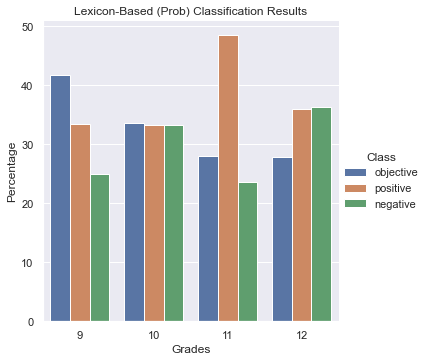

In [180]:
x, y = 'Grade', 'Class'

plot_collective = (merged_prob_results
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y, kind='bar'))

plot_collective.set(xlabel="Grades", ylabel = "Percentage", title='Lexicon-Based (Prob) Classification Results')
plt.savefig('lexprob.png', dpi=900, bbox_inches='tight')

In [173]:
frames_count = [df_classified9_count, df_classified10_count, df_classified11_count, df_classified12_count]

merged_count_results = pd.concat(frames_count)

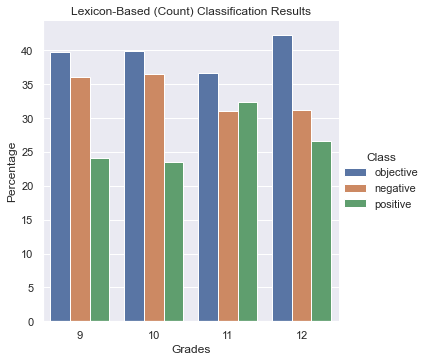

In [179]:
x, y = 'Grade', 'Class'

plot_collective = (merged_count_results
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y, kind='bar'))

plot_collective.set(xlabel="Grades", ylabel = "Percentage", title='Lexicon-Based (Count) Classification Results')

plt.savefig('lexcount.png', dpi=900, bbox_inches='tight')